# Определение сложности фильма

Разработка ML решение для автоматического определения уровня сложности англоязычных фильмов по его субтитрам. Процент понимания учеником слов должен составлять 50-70%, если процент меньше - ученик не поймет смысл фильма, если больше - ученик получит меньше нового материала. 

Ход работы: 
1. Изучение данных
2. Предобработка данных
3. Прасинг Оксфордского словаря
4. Создание и обработка субтитров
5. Подготовка признаков
6. Разбивка на выборки, обучение модели, анализ признаков
7. Вывод

## 1. Изучение данных

Импортируем необходимые модули

In [1]:
!pip install pysrt

In [2]:
import pysrt 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import glob
import os
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool
import pickle


import warnings
warnings.simplefilter('ignore')


Откроем таблицу с названиями фильмов и их уровнями 

In [3]:
try:
    df = pd.read_excel(r'C:/Users/0727G/Desktop/Projects/Уровень английского/movies_labels.xlsx')
except:
    df = pd.read_csv(r'English_scores/movies_labels.xlsx')

In [4]:
display(df)

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


Добавим столбец с имененм файла, это пригодится при открытии субтитров, когда будем указывать путь к файлу.

In [5]:
df['filename'] = df['Movie'] + '.srt' # Для дальнейшего вытаскивания субтитров в текст

Посчитаем количетсво файлов с субтитрами в нашем распоряжении

In [6]:
srt_files = []
srt_files += glob.glob(os.path.join(f'C:/Users/0727G/Desktop/Projects/Уровень английского/Subtitles_all/', '*.srt'))

In [7]:
a = 0
for j in srt_files:
    a += 1
print(f'Количество файлов с субтитрами: {a}')

Количество файлов с субтитрами: 278


Отдельно выделим имена файлов с субтитрами и создадим с ними датафрейм

In [8]:
names = []
for j in srt_files:
    names.append(os.path.basename(j))

In [9]:
subtit = pd.DataFrame(data=names, columns=['filename'])

Посмотрим нна файлы с субтитрами уровень к которым неопределен

In [10]:
subtit.loc[subtit['filename'].isin(df['filename']) == False]

,filename
19,Breaking_Bad_The_Movie(2017).srt
20,Bren╨Т.Brown.The.Call.to.Courage.2019.720.NF.7...
24,Casper.srt
47,"Crown, The S01E01 - Wolferton Splash.en.SDH.srt"
48,"Crown, The S01E01 - Wolferton Splash.en.srt"
49,"Crown, The S01E02 - Hyde Park Corner.en.SDH.srt"
50,"Crown, The S01E02 - Hyde Park Corner.en.srt"
51,"Crown, The S01E03 - Windsor.en.FORCED.srt"
52,"Crown, The S01E03 - Windsor.en.SDH.srt"
53,"Crown, The S01E03 - Windsor.en.srt"


Посмотрим на записи в df к которым нет файлов с субтитрами

In [11]:
df.loc[df['filename'].isin(subtit['filename']) == False]

,id,Movie,Level,filename
81,81,The Secret Life of Pets.en,B2,The Secret Life of Pets.en.srt
106,106,Up (2009),A2/A2+,Up (2009).srt
235,235,Glass Onion,B2,Glass Onion.srt
236,236,Matilda(2022),C1,Matilda(2022).srt
237,237,Bullet train,B1,Bullet train.srt
238,238,Thor: love and thunder,B2,Thor: love and thunder.srt
239,239,Lightyear,B2,Lightyear.srt
240,240,The Grinch,B1,The Grinch.srt


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        241 non-null    int64 
 1   Movie     241 non-null    object
 2   Level     241 non-null    object
 3   filename  241 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.7+ KB


In [13]:
df.drop_duplicates(inplace = True)

In [14]:
display(df['Level'].value_counts())

B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: Level, dtype: int64

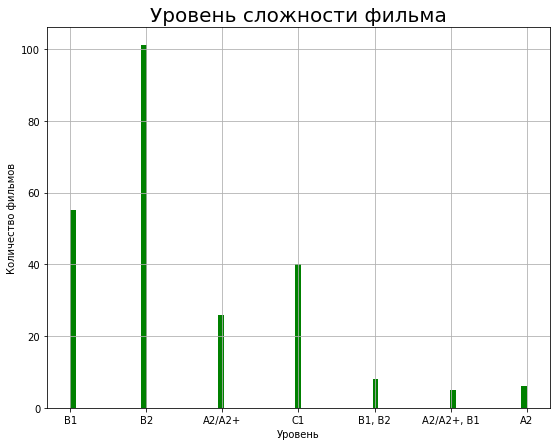

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.hist(df['Level'], bins=77, color='g')
ax.set_title('Уровень сложности фильма', fontdict = {'fontsize': 20})
plt.xlabel('Уровень')
plt.ylabel('Количество фильмов')
ax.grid()
plt.show()

In [16]:
df.loc[df['Level'] == 'A2']

,id,Movie,Level,filename
112,112,The Walking Dead-S01E01-Days Gone Bye.English,A2,The Walking Dead-S01E01-Days Gone Bye.English.srt
113,113,The Walking Dead-S01E02-Guts.English,A2,The Walking Dead-S01E02-Guts.English.srt
114,114,The Walking Dead-S01E03-Tell It To The Frogs.E...,A2,The Walking Dead-S01E03-Tell It To The Frogs.E...
115,115,The Walking Dead-S01E04-Vatos.English,A2,The Walking Dead-S01E04-Vatos.English.srt
116,116,The Walking Dead-S01E05-Wildfire.English,A2,The Walking Dead-S01E05-Wildfire.English.srt
117,117,The Walking Dead-S01E06-TS-19.English,A2,The Walking Dead-S01E06-TS-19.English.srt


In [17]:
df.loc[df['Level'] == 'A2/A2+']

,id,Movie,Level,filename
4,4,Aladdin(1992),A2/A2+,Aladdin(1992).srt
5,5,All_dogs_go_to_heaven(1989),A2/A2+,All_dogs_go_to_heaven(1989).srt
6,6,An_American_tail(1986),A2/A2+,An_American_tail(1986).srt
7,7,Babe(1995),A2/A2+,Babe(1995).srt
8,8,Back_to_the_future(1985),A2/A2+,Back_to_the_future(1985).srt
10,10,Batman_begins(2005),A2/A2+,Batman_begins(2005).srt
19,19,Cast_away(2000),A2/A2+,Cast_away(2000).srt
27,27,Dredd(2012),A2/A2+,Dredd(2012).srt
31,31,Eurovision_song_contest_(2020),A2/A2+,Eurovision_song_contest_(2020).srt
34,34,Finding_Nemo(2003),A2/A2+,Finding_Nemo(2003).srt


Как видим в целевом признаке преобладает категория B2, а также существуют фильмы с категориями A2/A2+, B1B2, A2/A2+ B1. Эти категории необходимо заменить. Попробуем их классифицировать моделью обученной на классах которые определены. Также исходное количество данных нам файлов 278, в отличии от информации имеющейся в df, 241 запись. При этом субтитры в данных файлах отсутсвуют для 7 фильмов, удалим их  в предобработке. 

## 2. Предобработка данных

Заменим A2/A2+ на A2

In [18]:
df['Level'] = df['Level'].replace({'A2/A2+':'A2', 'B1, B2': 'B2', 'A2/A2+, B1':'B1'})

In [19]:
df

,id,Movie,Level,filename
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016).srt
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999).srt
2,2,A_knights_tale(2001),B2,A_knights_tale(2001).srt
3,3,A_star_is_born(2018),B2,A_star_is_born(2018).srt
4,4,Aladdin(1992),A2,Aladdin(1992).srt
...,...,...,...,...
236,236,Matilda(2022),C1,Matilda(2022).srt
237,237,Bullet train,B1,Bullet train.srt
238,238,Thor: love and thunder,B2,Thor: love and thunder.srt
239,239,Lightyear,B2,Lightyear.srt


Удалим данные к которым у нас нет субтитров

In [20]:
df = df.drop(df.loc[df['filename'].isin(subtit['filename']) == False].index).reset_index(drop=True)

## 3. Парсинг оксфордского словаря

Парсинг словаря проходил в отдельном ноутбуке, который также будет отправлен во вложении. Откроем получившийся файл

In [21]:
Oxford = pd.read_csv(r'C:/Users/0727G/Desktop/Projects/Уровень английского/Oxford_classififcation.csv')
Oxford

,words,level
0,the,A1
1,american,A1
2,tree,A2
3,restaurant,A2
4,eighty,A2
...,...,...
3331,permanently,C1
3332,tsunami,C1
3333,sustainable,C1
3334,cheek,C1


## 4. Создание и обработка субтитров

Используя библиотеку pysrt для открытия файлов субтитров произведем с полученным текстом следующее:
#####  1. Удаление лишних слов и символов (признаков начала и конца фраз, лишние символы и  слова(цвет фона и т.п.), имена тех, кому принадлежит диалог)
##### 2. Обработку текста(приведение к нижнему регистру, лемматизация, удаление стоп-слов)
##### 3. Извлечение признаков



Для этого понадобится дозагрузить некоторые модели:


In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\0727G\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\0727G\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0727G\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\0727G\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [23]:
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

Описание функции: функция открывает файл srt, затем обрабатывает текст регулярными выражениями, оставляя предложения нижнего регистра(подробнее в коде). Далее определяется скорость речи (этот показатель очень важен, ведь чем быстрее речь, тем ее сложнее воспринимать и для конечного потребителя это необходимо учитывать, несмотря на то, что это может занизить метрики, т.к. оценки поставлены без учета этого фактора). 

In [24]:
def sub_preprocessing(filename):
    # Читаем файл субтитров
    try:
        try:
            subs = pysrt.open('C:/Users/0727G/Desktop/Projects/Уровень английского/Subtitles_all/' + filename, encoding='iso-8859-1')
        except:
            subs = pysrt.open('English_level/Subtitles_all/' + filename, encoding='iso-8859-1')
    
  
        film_start = subs[0].start.hours*3600 + subs[0].start.minutes*60 + subs[0].start.seconds # Время начала фольма

        if subs[-1].index - subs[-2].index < 2:
                film_end = subs[-1].end.hours*3600 + subs[-1].end.minutes*60 + subs[-1].end.seconds # Время окончания фильма
        else:
                film_end = subs[-2].end.hours*3600 + subs[-2].end.minutes*60 + subs[-2].end.seconds
        
    
        film_start, film_end = min(film_start, film_end), max(film_start, film_end)
        film_lenght = film_end - film_start # Продолжительность фильма
        # Далее почистим текст
        text = re.sub(r'\<.*?\>', '', subs.text) # Удалим <> и все что в них
        text = re.sub(r'\n', '', text) # Удалим знаки переноса строки
        text = re.sub(r'\(.*?\)', '', text) # Удалим () и все что в них
        text = re.sub('\[.*?\]', '', text)  # Удаляем то что в скобках []
        text = re.sub('[A-Z]+?:', '', text) # Удаляем слова написанные заглавными буквами с двоеточием(это имена тех кто говорит)
        text = re.sub('\.+?:', '\.', text)  # Заменяем троеточия на одну точку
        text = text.lower()
        text = re.sub('[^a-z\.\!\?]', ' ', text) # Удаляем всё что не буквы и не .?!
        text = re.sub(' +', ' ', text) # Удаляем " +"
    
        num_sentence = len(re.split('[\.\?\!]', text)) # Количетсво предложений
    
        morphs = [_[1] for _ in nltk.pos_tag(re.sub('\n', ' ', text).lower().split(' '))] # Морфологический разбор 
        gerund = morphs.count('VBG')  # Герундий
        text_no_preproc = text
        text = re.sub('[^a-z]', ' ', text) # Удалим всё что не буквы
        text_len = len(text) # Количество символов
        sub_per_second = text_len / film_lenght # Букв в секунду
    
        for stop_word in sw.words('english'):
            text = re.sub(f' {stop_word} ', ' ', text) # Удалим стоп-слова
        
        text = re.sub(' [a-z] ', ' ', text) # Удалим однобуквенные слова
    
        words = text.split(' ')
        words_unique = []
        for word in words:
             if word not in words_unique:
                words_unique.append(word) # Список уникальных слов
    
        sub_per_word = (text_len - len(words)) / len(words)
        
     
        difficulty = {'A2':0,
                      'B1':0,
                      'B2':0,
                      'C1':0} # Расчитаем количество слов разной сложности в фильме

        for word in words_unique:
            match = Oxford[Oxford['words'] == word]['level'].values
            if len(match) > 0:
                for lvl in match:
                    difficulty[lvl] += 1

        wnl = WordNetLemmatizer()
        text = ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in text.split(' ')]) # Лемматизация
        phrases_lenght = 0  # Посчитаем продолжительность всех фраз
        for sub in subs:   
            phrase_start = sub.start.hours*3600 + sub.start.minutes*60 + sub.start.seconds # Время начала фразы
            phrase_end = sub.end.hours*3600 + sub.end.minutes*60 + sub.end.seconds # Время окончания фразы
            phrases_lenght += max(0, phrase_end - phrase_start) # Продолжительность фразы
            if phrases_lenght != 0:
                sub_per_second_frases = text_len / phrases_lenght

        return [len(text), # Возвращаем результаты
                sub_per_second, 
                phrases_lenght,
                sub_per_second_frases,
                sub_per_word,
                max(num_sentence, len(subs)),
                len(words) / max(num_sentence, len(subs)),
                difficulty['A2']/len(words_unique),
                difficulty['B1']/len(words_unique),
                difficulty['B2']/len(words_unique),
                difficulty['C1']/len(words_unique),
                1 - (difficulty['A2'] + difficulty['B1'] + difficulty['B2'] + difficulty['C1'])/len(words_unique),
                len(words_unique),
                len(words_unique)/film_lenght,
                len(words_unique)/len(words),
                gerund,
                gerund/num_sentence]
    except:
        return [-1,
                -1, 
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1]





Добавим новые столбцы в наш датафрейм

In [25]:
%%time
new_columns =  ['text_len', # Ячейка выполняется 9 минут!!!
                'sub_per_second',
                'phrases_lenght',
                'sub_per_second_frases',
                'sub_per_word',
                'num_sentence',
                'word_persentence',
                'A2',
                'B1',
                'B2',
                'C1', 
                'B1+',
                'words_unique_count',
                'words_unique_per_second',
                'words_unique_part',
                'gerund',
                'gerund_per_sentence']

df[new_columns] = [sub_preprocessing(i) for i in df['filename']]

Wall time: 9min 19s


## 5. Подготовка признаков

In [26]:
df

,id,Movie,Level,filename,text_len,sub_per_second,phrases_lenght,sub_per_second_frases,sub_per_word,num_sentence,...,A2,B1,B2,C1,B1+,words_unique_count,words_unique_per_second,words_unique_part,gerund,gerund_per_sentence
0,0,10_Cloverfield_lane(2016),B1,10_Cloverfield_lane(2016).srt,13915,4.219074,2083,11.723476,8.539062,1064,...,0.267241,0.138889,0.100575,0.013410,0.479885,1044,0.180373,0.407813,103,0.103000
1,1,10_things_I_hate_about_you(1999),B1,10_things_I_hate_about_you(1999).srt,24600,7.288085,2897,14.400069,8.070885,1660,...,0.208738,0.115898,0.091626,0.020024,0.563714,1648,0.287911,0.358339,148,0.089157
2,2,A_knights_tale(2001),B2,A_knights_tale(2001).srt,23107,4.726434,3029,12.348960,7.183111,2201,...,0.218267,0.139691,0.084621,0.015447,0.541974,1489,0.188148,0.325749,59,0.026806
3,3,A_star_is_born(2018),B2,A_star_is_born(2018).srt,36041,7.730812,5000,12.550200,7.905904,2559,...,0.204082,0.119048,0.064059,0.013039,0.599773,1764,0.217322,0.250355,246,0.096131
4,4,Aladdin(1992),A2,Aladdin(1992).srt,25270,7.463956,3978,9.968829,7.566861,1669,...,0.172998,0.113968,0.068381,0.025132,0.619521,1711,0.322040,0.369626,77,0.046135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,230,Suits.S03E06.720p.HDTV.x264-mSD,C1,Suits.S03E06.720p.HDTV.x264-mSD.srt,18268,12.352433,2055,15.315815,9.838154,1068,...,0.209335,0.099010,0.063649,0.014144,0.613861,1414,0.554945,0.486915,127,0.136853
229,231,Suits.S03E07.HDTV.x264-mSD,C1,Suits.S03E07.HDTV.x264-mSD.srt,19697,12.728385,2087,15.448491,9.736264,1023,...,0.159581,0.094179,0.060170,0.013080,0.672989,1529,0.603632,0.509158,92,0.097354
230,232,Suits.S03E08.480p.HDTV.x264-mSD,C1,Suits.S03E08.480p.HDTV.x264-mSD.srt,19011,12.815312,2072,15.672780,9.978364,1007,...,0.185962,0.099132,0.060058,0.013748,0.641100,1382,0.545383,0.467208,96,0.103004
231,233,Suits.S03E09.480p.HDTV.x264-mSD,C1,Suits.S03E09.480p.HDTV.x264-mSD.srt,19693,13.235502,2050,16.476585,9.655205,1025,...,0.186685,0.107069,0.068634,0.013727,0.623885,1457,0.570925,0.459621,115,0.112195


Удалим субтитры, которые не удалось обработать(ошибка в файлах, т.к. проблема вылезает в film_start)

In [27]:
df.loc[df['text_len'] == -1]

,id,Movie,Level,filename,text_len,sub_per_second,phrases_lenght,sub_per_second_frases,sub_per_word,num_sentence,...,A2,B1,B2,C1,B1+,words_unique_count,words_unique_per_second,words_unique_part,gerund,gerund_per_sentence
6,6,An_American_tail(1986),A2,An_American_tail(1986).srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
9,9,Banking_On_Bitcoin(2016),C1,Banking_On_Bitcoin(2016).srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
13,13,Before_sunrise(1995),B2,Before_sunrise(1995).srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
14,14,Before_sunset(2004),B2,Before_sunset(2004).srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
16,16,Bridget_Jones_diary(2001),B2,Bridget_Jones_diary(2001).srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,221,Suits S04E13 EngSub,C1,Suits S04E13 EngSub.srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
220,222,Suits S04E14 EngSub,C1,Suits S04E14 EngSub.srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
221,223,Suits S04E15 EngSub,C1,Suits S04E15 EngSub.srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0
222,224,Suits S04E16 EngSub,C1,Suits S04E16 EngSub.srt,-1,-1.0,-1,-1.0,-1.0,-1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1,-1.0


In [28]:
df = df.drop(df.loc[df['text_len'] == -1].index).reset_index(drop=True)

In [29]:
df = df.dropna().reset_index(drop=True)

Анализ

<AxesSubplot:>

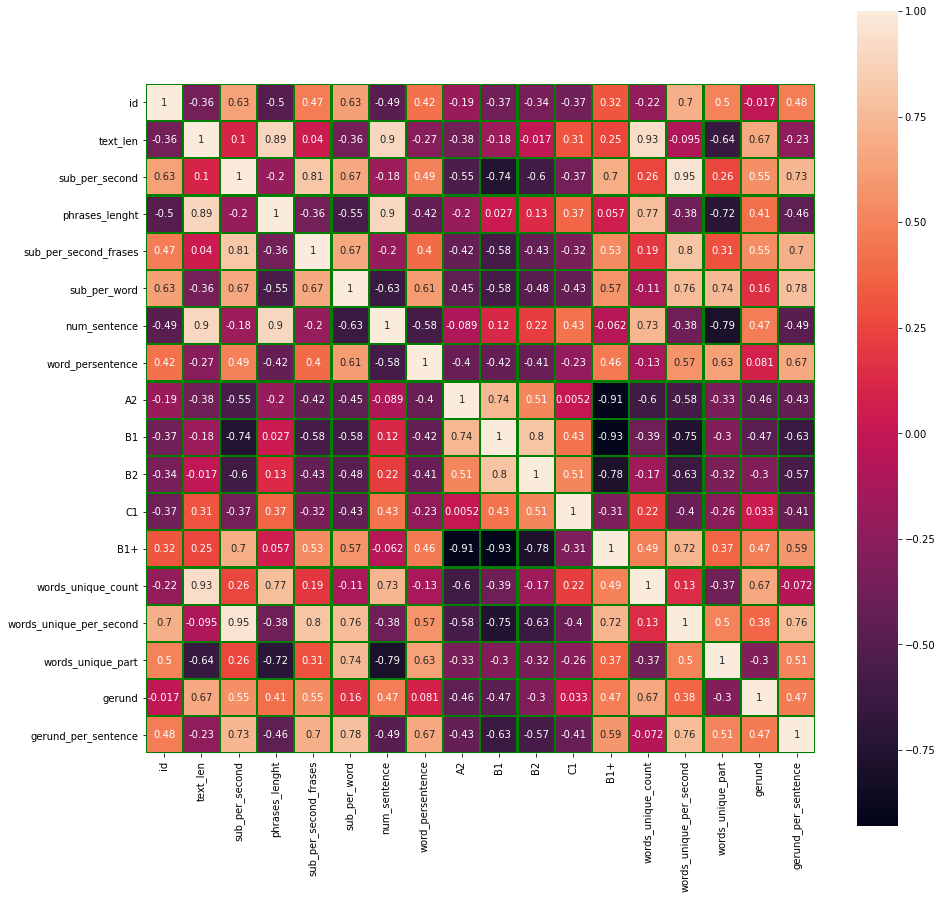

In [30]:
corr = df.corr()


fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, annot=True, linewidths=1.2, linecolor='g')


Удаим столбцы, которые не несут никакой информативности для модели

In [31]:
df.drop(columns = ['id', 'filename', 'Movie'], axis=0, inplace=True)


In [32]:
df.columns

Index(['Level', 'text_len', 'sub_per_second', 'phrases_lenght',
       'sub_per_second_frases', 'sub_per_word', 'num_sentence',
       'word_persentence', 'A2', 'B1', 'B2', 'C1', 'B1+', 'words_unique_count',
       'words_unique_per_second', 'words_unique_part', 'gerund',
       'gerund_per_sentence'],
      dtype='object')

## 6. Разбивка на выборки, обучение модели, анализ признаков

Произведем разбивку на выборки

In [33]:
target = df['Level']
features = df.drop(columns = ['Level'], axis=0)

In [34]:
features_train, features_test_valid, target_train, target_train_valid = train_test_split(features, target, test_size = 0.55, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test_valid,  target_train_valid, test_size = 0.5, random_state=12345)

In [35]:
# Проверим размеры выборок
pd.DataFrame({'features_train':[features_train.shape[0], features_train.shape[1]],
              'target_train':[target_train.shape[0], 1],
              'features_valid':[features_valid.shape[0], features_valid.shape[1]],
              'target_valid':[target_valid.shape[0], 1],
              'features_test':[features_test.shape[0], features_test.shape[1]],
              'target_test':[target_test.shape[0], 1],
             },
              index=['index','columns']
            )

,features_train,target_train,features_valid,target_valid,features_test,target_test
index,69,69,43,43,42,42
columns,17,1,17,1,17,1


Для модели CatBoostClassifier сформируем пулы

In [36]:
train_pool = Pool(data=features_train,
                  label=target_train)
valid_pool = Pool(data=features_valid,
                   label=target_valid)
test_pool = Pool(data=features_test,
                   label=target_test)

learn_pool = Pool(data=pd.concat([features_train, features_valid]),
                  label=pd.concat([target_train, target_valid]))

Напишем функцию с использованием алгоритма CatBoostClassifier, которая выдает обученную модель

In [37]:
def fit_model(train_pool, valid_pool, **kwargs):
    model = CatBoostClassifier(
                               eval_metric='Accuracy',
                               od_type='Iter',
                               od_wait=500,
                               tokenizers=
                                     [{'tokenizer_id': 'Sense',
                                       'separator_type': 'BySense',
                                       'lowercasing': 'True',
                                       'token_types':['Word', 'Number', 'SentenceBreak'],
                                       'sub_tokens_policy':'SeveralTokens'
                                      }],
                                     dictionaries = [{'dictionary_id': 'Word','max_dictionary_size': '1000'}],
                                     feature_calcers = ['BoW:top_tokens_count=1000'],
                               **kwargs
                              )
    return model.fit(train_pool,
                     eval_set=valid_pool,
                     verbose=100,
                     plot=True,
                     use_best_model=True)

Обучим модель

In [38]:
%%time
model = fit_model(train_pool,
                  valid_pool,
                  iterations=17,
                  learning_rate=0.13,
                  max_depth=6,
                  l2_leaf_reg=2,
                  random_seed=12345
                )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6376812	test: 0.6279070	best: 0.6279070 (0)	total: 169ms	remaining: 2.7s
16:	learn: 0.9275362	test: 0.6279070	best: 0.6511628 (9)	total: 290ms	remaining: 0us

bestTest = 0.6511627907
bestIteration = 9

Shrink model to first 10 iterations.
Wall time: 441 ms


Посчитаем метрики f1 и accuracy на тестовой выборке

In [39]:
preds = model.predict(test_pool)
f1_score(preds, target_test, average='weighted')

0.6170600414078675

In [40]:
accuracy_score(preds, target_test)

0.5238095238095238

Сохраним модель

In [41]:
with open("C:/Users/0727G/Desktop/Projects/Уровень английского/sub_model.pcl", "wb") as fid:
    pickle.dump(model,fid)

In [42]:
model.save_model('catboostclassifier_model.cbm')

Проверка фиктивной моделью

In [43]:
clases = target.value_counts()
clases

B2    82
B1    36
A2    21
C1    15
Name: Level, dtype: int64

In [44]:
clases.max() /  clases.sum()

0.5324675324675324

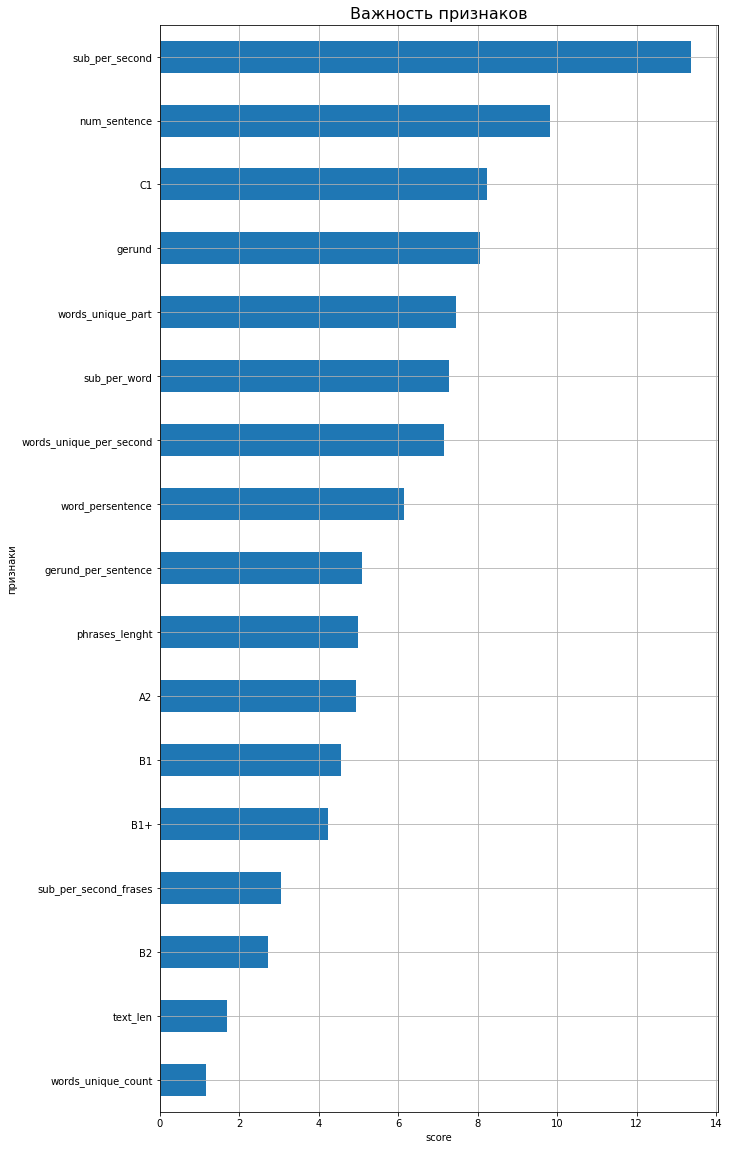

In [45]:
efectiv_score = pd.DataFrame(data={'score': model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

Наиболее важные признаки: Количетсво букв в секунду, частота уникальных слов, количетсво уникальных слов в секунду, продолжительность фразы, количество предложений. Модель показала низкую точность, но мтерика f1 показала неплохой результат, в нашей задаче преобладают фильмы класса B2, причем значительно, однако определение других классов одинаково важно, ведь пользователь может выложить файл любого уровня, в зависимости от его предпочтений, к примеру, если это подросток, возможно он чаще смотрит мультфильмы, которые обладают уровнем A2, но если мы посмотрим на любителя посмотреть научные фильмы, то с такого клиента мы будем чаще получать фильмы категории C1. Поэтому используем метрику f1 и считаем нашу модель удовлетворительной.

## 7. Вывод

На осонове имеющихся данных произвели работу по созданию модели, определяющего сложность английского в фильмах. В целевом признаке преобладает категория B2. В ходе работы была произведена обработка исходных данных, обработка текстов субтитров, создание признаков на основе текстов, обучение модели на основе алгоритма градиентного бустинга. Наиболее важные признаки: Количетсво букв в секунду, частота уникальных слов, количетсво уникальных слов в секунду, продолжительность фразы, количество предложений. Модель показала низкую точность, но мтерика f1 показала неплохой результат, в нашей задаче преобладают фильмы класса B2, причем значительно, однако определение других классов одинаково важно, ведь пользователь может выложить файл любого уровня, в зависимости от его предпочтений, к примеру, если это подросток, возможно он чаще смотрит мультфильмы, которые обладают уровнем A2, но если мы посмотрим на любителя посмотреть научные фильмы, то с такого клиента мы будем чаще получать фильмы категории C1. Поэтому используем метрику f1 и считаем нашу модель удовлетворительной.